In [1]:
import sys
path = "../"
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    path = "./drive/MyDrive/566 Project"
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
%%capture
!pip install transformers

In [3]:
import gc
import pickle as pkl 
from tqdm import tqdm
import psutil
import numpy as np
# load data into dataset object for dataloader
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import transformers
from transformers import ViTMAEForPreTraining, AutoImageProcessor
import matplotlib.pyplot as plt


In [4]:
# match adversarial image (input) with clean image (target)

# had to split up pickle files for size

# data = [] # [[adv_0, clean_0], ..., [adv_k, clean_k]]

def load_data(file_names, image_processor):
    datasets = []
    for f in file_names:
        data = open(path+"data/"+f, 'rb')
        datasets.append(pkl.load(data))
    # data = open(path+"data/"+file_name2, 'rb')
    # data2 = pkl.load(data)
    unprocessed_data = []
    for d in datasets:
        unprocessed_data += d
    # unprocessed_data = (data1 + data2)
    # unprocessed_data = data1
    print("Total Images",len(unprocessed_data))
    print("Processing Data...")
    data = []
    for i in tqdm(range(len(unprocessed_data))):
        name, n,c = unprocessed_data[i]
        if len(n.shape) == 3 and len(c.shape) == 3: 
            n = image_processor(images=n, return_tensors="pt")
            c = image_processor(images=c, return_tensors="pt")
            data.append([name, n,c])
    print("\nData Processed:",len(data))
    return data

In [5]:
# pretrained MAE model and image processor

def load_model(model, finetune="None"):
    model_type = "base"
    if finetune == "gaussian_noise":
        model_type = "finetuned on gaussian"
        checkpoint_path = path+'checkpoints/100epochtrain.bin'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        msg = model.load_state_dict(checkpoint, strict=False)
    if finetune == "fgsm":
        model_type = "finetuned on fgsm"
        checkpoint_path = path+'checkpoints/fgsm_model.bin'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        msg = model.load_state_dict(checkpoint, strict=False)
    
    print("Using model",model_type)
    return model   
    

In [6]:
class DS(Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()
        self.data = data
        
    def __len__(self):
        return len(data)

    def __getitem__(self, index):
        # print(self.__len__() , index)
        assert self.__len__() > index
        return self.data[index][0], self.data[index][1], self.data[index][2]
    
    def getname(self, index):
        assert self.__len__() > index
        return self.data[index][0]

In [7]:
def custom_forward(x, model, noise=None, viz=True, recon_and_vis = True):
    outs = model.forward(x, noise)
    loss = outs["loss"]
    y = outs["logits"]
    mask = outs["mask"]
    y_ = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y_).detach()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, 16**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach()
    x = torch.einsum('nchw->nhwc', x)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    if viz:

        # masked image
        im_masked = x * (1 - mask)

        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[2], "original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[2], "masked")

        plt.subplot(1, 4, 3)
        show_image(y[2], "reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[2], "reconstruction + visible")

        plt.show()
    if recon_and_vis:
        return im_paste
    else:
        return y

In [8]:
def show_image(image, title='', is_numpy=True):
    imagenet_std = torch.tensor(image_processor.image_std)
    imagenet_mean = torch.tensor(image_processor.image_mean)
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if is_numpy:
        plt.imshow(torch.from_numpy(image))
    else:
        plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
def sanity_check(test_dataloader):
    l, noisy, clean = next(iter(test_dataloader))
    seq_length=196
    noise = torch.rand(8, seq_length)
    noisy_inputs = noisy.pixel_values.view(8,3,224,224)
    clean_inputs = clean.pixel_values.view(8,3,224,224)
    print("Noisy Images")
    rec_1 = custom_forward(noisy_inputs, model, noise, viz=True).detach() 
    print("Clean Images")
    rec_1 = custom_forward(clean_inputs, model, noise, viz=True).detach() 

In [9]:
def reconstruct(model, masking_ratio, inputdata, viz, recon_and_vis):
    
    model.config.mask_ratio = masking_ratio
    model.eval()
    device = "cuda"
    model.to(device)

    first_pass_img = []
    first_pass_label = []
    second_pass_img = [] 

    seq_length=196

    stop = 1000


    for i, (name, noise_input, clean_input) in enumerate(tqdm(test_dataloader)):

        batch_size = noise_input.pixel_values.size()[0]

        noise = torch.rand(batch_size, seq_length).to(device)

        if inputdata == "noise":
            inputs = noise_input.pixel_values.view(batch_size,3,224,224).to(device)  
        if inputdata == "clean":
            inputs = clean_input.pixel_values.view(batch_size,3,224,224).to(device) 
        
        rec_1 = custom_forward(inputs, model, noise, viz, recon_and_vis).detach()  

        noise = torch.rand(batch_size, seq_length).to(device)

        rec_2 = custom_forward(torch.einsum('nhwc->nchw', rec_1), model, noise, viz, recon_and_vis).detach()

        rec_1 = rec_1.to(device='cpu').numpy()
        rec_2 = rec_2.to(device='cpu').numpy()


        first_pass_img.extend(rec_1)
        second_pass_img.extend(rec_2)
        first_pass_label.extend(name)

        del rec_1, rec_2

    print("\n Reconstruction Done! :D")
    return first_pass_img, first_pass_label, second_pass_img

In [10]:
# denormalizing images and converting back to RGB
def denorm_imgs(image_list):
    denorm_img = []
    imagenet_mean = np.array(image_processor.image_mean)
    imagenet_std = np.array(image_processor.image_std)
    for image in image_list:
        denorm_img.append(torch.clip((torch.from_numpy(image)* imagenet_std + imagenet_mean) * 255, 0, 255).int().numpy())
    return denorm_img

In [11]:
def pickle_output(output, filename, masking_ratio):
    fileObject = open(path+f"data/{filename}_{int(masking_ratio*100)}.pkl", 'wb')
    pkl.dump(output, fileObject)
    fileObject.close()

In [12]:
image_processor = AutoImageProcessor.from_pretrained('facebook/vit-mae-base')
model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base')

In [16]:
#Set MASKING_RATIO, FINETUNE, INPUT_DATA, RECON_AND_VIS

INPUT_DATA = "noise" #["noise", "clean"]
RECON_AND_VIS = False  # return image with reconstruction and visible patches when set to True
FINETUNE = "gaussian_noise"  #[None, gaussian_noise, fgsm]
MASKING_RATIO = 0.50

FILE_NAMES = ["test1_cropped_name", "test2_cropped_name"]
# FILE_NAME1 = "test1_cropped_name"
# FILE_NAME2 = "test2_cropped_name"

OUTPUT_FILE = "recon_vis" if RECON_AND_VIS else "recon"

OUTPUT_FILE1 = INPUT_DATA+"_"+OUTPUT_FILE+"_pass_1_"+"image_"+FINETUNE
OUTPUT_FILE2 = INPUT_DATA+"_"+OUTPUT_FILE+"_pass_2_"+"image_"+FINETUNE
OUTPUT_LABEL = INPUT_DATA+"_"+OUTPUT_FILE+"_labels_"+"image_"+FINETUNE

print("Starting Process...")

# data = load_data(file_name1=FILE_NAME1, file_name2=FILE_NAME2, image_processor=image_processor)
data = load_data(file_names=FILE_NAMES, image_processor=image_processor)

model = load_model(model, finetune=FINETUNE)

ds = DS(data)
test_dataloader = DataLoader(ds, batch_size=8, shuffle=True)

print("\nRunning model on", INPUT_DATA)
print("Masking Ratio set to", MASKING_RATIO)
print("Saving Images with", OUTPUT_FILE)

first_pass_img, img_labels, second_pass_img = reconstruct(model,
                                                          masking_ratio=MASKING_RATIO, 
                                                          inputdata=INPUT_DATA,
                                                          viz = False,
                                                          recon_and_vis = RECON_AND_VIS)

denorm_first_pass = denorm_imgs(first_pass_img)
denorm_second_pass = denorm_imgs(second_pass_img)


print("\nSaving Images in Pickle File")
pickle_output(denorm_first_pass, OUTPUT_FILE1, MASKING_RATIO)
pickle_output(denorm_second_pass, OUTPUT_FILE2, MASKING_RATIO)
pickle_output(img_labels, OUTPUT_LABEL,MASKING_RATIO)

print("\nProcess Done!!")

Starting Process...
Total Images 8993
Processing Data...


100%|██████████| 8993/8993 [00:38<00:00, 235.64it/s]



Data Processed: 8817
Using model finetuned on gaussian

Running model on noise
Masking Ratio set to 0.5
Saving Images with recon


100%|██████████| 1103/1103 [03:24<00:00,  5.39it/s]



 Reconstruction Done! :D

Saving Images in Pickle File

Process Done!!



Displaying recreated image


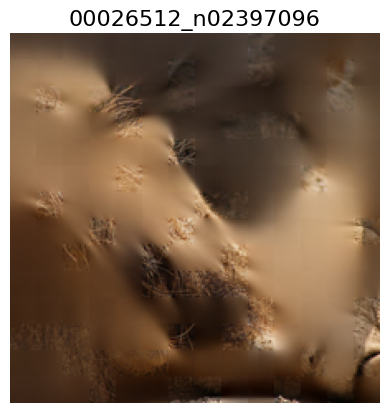

In [23]:
print("\nDisplaying recreated image")
#display first pass
show_image(denorm_first_pass[0], img_labels[0])

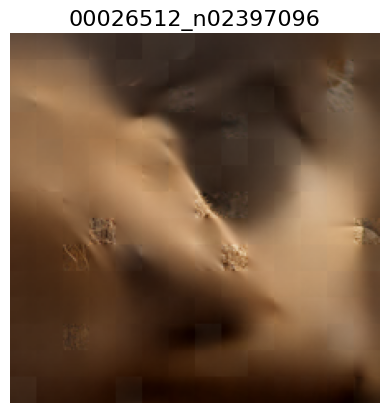

In [24]:
# display second pass
show_image(denorm_second_pass[0], img_labels[0])

=======IGNORE======

In [33]:
# masking_ratios = [0.25]
# for mr in masking_ratios:
#     first_pass_img, first_pass_label, second_pass_img = reconstruct(masking_ratio=mr, inputdata="noise")
#     denorm_first_pass_img = denorm_imgs(first_pass_img)
#     denorm_second_pass_img = denorm_imgs(second_pass_img)
    
#     pickle_output(denorm_first_pass_img, "recon_visible_1_image_denorm", model.config.mask_ratio)
#     pickle_output(first_pass_label, "recon_visible_labels_denorm", model.config.mask_ratio)
#     pickle_output(denorm_second_pass_img, "recon_visible_2_image_denorm", model.config.mask_ratio)
#     print(f"Masking ratio {mr} completed!")
#     del first_pass_img, first_pass_label, second_pass_img, denorm_first_pass_img, denorm_second_pass_img

100%|██████████| 623/623 [02:21<00:00,  4.42it/s]



Done! :D
Masking ratio 0.25 completed!


In [ ]:
# for d in data:
#   l = d[0]
#   if l == first_pass_label[1]:
#     noiseimg = torch.einsum('chw->hwc', d[1].pixel_values.view(3,224,224))
#     cleanimg = torch.einsum('chw->hwc', d[2].pixel_values.view(3,224,224))
#     show_image(cleanimg)
#   # print(l, noiseimg.pixel_values.view(3,224,224), cleanimg.pixel_values.shape)
#     break

In [ ]:
# back to denormalize and RGB space 